Importy

In [1]:
import tensorflow as tf
from PIL import Image
import numpy as np
import IPython.display as display

Funkce pro stáhnutí obrázku (parametr maxSize pro zmenšení obrázku)

In [2]:
def download(url, name, maxSize=None):
  imgPath = tf.keras.utils.get_file(name, origin=url)
  img = Image.open(imgPath);
  if maxSize:
    img.thumbnail(maxSize)
  return np.asarray(img)

Vykreslení staženého obrázku

In [3]:
def show(img):
  display.display(Image.fromarray(np.asarray(img)))

Načtení nějakého obrázkuu pro zpracování

228763/228763 [==============================] - 0s 1us/step


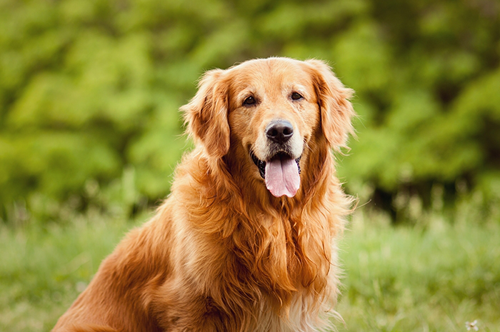

In [4]:
pictureUrl = "https://www.spokojenypes.cz/ImgP.ashx?co=/ImgGalery/Img1/Atlas/170510090202-20336760-xxl-jpg.jpg&fd=a2&pa=1"
downloadedImg = download(pictureUrl, "retriever", maxSize=(500, 500))
show(downloadedImg)

Stáhnutí předtrénovaného modelu - https://keras.io/api/applications/inceptionv3/

In [5]:
model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

87910968/87910968 [==============================] - 4s 0us/step


Výběr vrstev z modelu (dostupné jsou mixed0 - mixed10, Vyšší vrstvy reagují na detaily jako jsou například oči a menší vrstvy na jednodušší předměty jako jsou hrany, různé objekty, ...)

In [6]:
layers = [model.get_layer(name).output for name in ['mixed0', "mixed1"]]

Inicializace "dream" modelu s využitím vybraných vrstev

In [7]:
dreamModel = tf.keras.Model(inputs=model.input, outputs=layers)

Funkce pro výpočet ztrátové hodnoty - ztrátová hodnota je součtem aktivací ve zvoledných vrstvách. Hodnota je normalizována v každé vrstvě, aby výsledná hodnota nepřevážila hodnoty z menších vrstev.

Standardní přístup je minimalizace ztrátové hodnoty pomocí gradientu. DeepDream k tomu přistupuje opačně - proto je ztrátová funkce maximalizována. 

In [8]:
def calculateLossValue(img, model):
  # Získání aktivací posláním vstupního obrázku do modelu
  imageBatch = tf.expand_dims(img, axis=0)
  activations = model(imageBatch)
  
  if len(activations) == 1:
    activations = [activations]

  # Výpočet průměru prvků - https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean
  losses = []
  for activation in activations:
    losses.append(tf.math.reduce_mean(activation))

  # Sečtení průměrů - https://www.tensorflow.org/api_docs/python/tf/math/reduce_sum
  return  tf.reduce_sum(losses)

Funkce pro výpočet gradientu a přidání zpět do původního obrázku. Přidáním gradientů se "zlepšují" vzory, které neuronová síť vidí (rozpoznává). V každém kroku se tedy obrázek překreslí a nová verze bude více podněcovat aktivace vrstev v modelu.

In [9]:
def calculateAndProcessGradient(model, img, steps, stepSize):

  print("Processing...")
  # defaultní ztrátová hodnota
  loss = tf.constant(0.0)

  for i in tf.range(steps):
    # Výpočet gradientu - https://www.tensorflow.org/api_docs/python/tf/GradientTape
    with tf.GradientTape() as g:
      g.watch(img)
      loss = calculateLossValue(img, model)
    gradients = g.gradient(loss, img)

    # Normalizace gradientu.
    gradients /= tf.math.reduce_std(gradients) + 1e-8 

    # Úprava obrázku
    img = img + gradients * stepSize
    img = tf.clip_by_value(img, -1, 1)

  return img

Funkce pro normalizaci, použití https://www.tensorflow.org/api_docs/python/tf/cast

In [10]:
def normalize(img):
  img = 255*(img+ 1.0)/2.0
  return tf.cast(img, tf.uint8)

Funkce pro spuštění DeepDreamu

In [11]:
def runDeepDream(img, steps, stepSize):
  # Konverze do vstupů očekávaných modelem
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  stepSize = tf.convert_to_tensor(stepSize)
  stepsToProcess = steps
  step = 0

  while stepsToProcess:
    if stepsToProcess > 100:
      currentRunSteps = tf.constant(100)
    else:
      currentRunSteps = tf.constant(stepsToProcess)
    stepsToProcess -= currentRunSteps
    step += currentRunSteps

    # procesování po batchi 100 kroků
    img = calculateAndProcessGradient(model=dreamModel, img=img, steps=currentRunSteps, stepSize=tf.constant(stepSize))
    display.clear_output(wait=True)
    show(normalize(img))


  result = normalize(img)
  display.clear_output(wait=True)
  show(result)

  return result

Test algoritmu

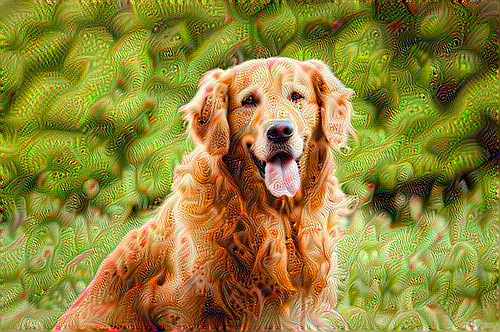

In [12]:
resultOfRun = runDeepDream(img=downloadedImg, steps=100, stepSize=0.01)

"Zlepšení" výstupu a rozlišení výsledku -> koncept je takový, že se spustí DeepDream, poté se zvětší vělikost obrázku a opět dojde ke spuštění DeepDreamu

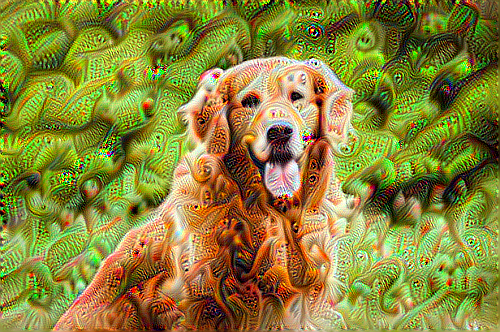

Processing...


In [ ]:
# Velikost o kolik se má udělat  resize
octScale = 1.3

img = tf.constant(np.array(downloadedImg))
baseShape = tf.shape(img)[:-1]
floatBaseShape = tf.cast(baseShape, tf.float32)
for n in range(-1, 4):
  # Resize
  newShape = tf.cast(floatBaseShape*(octScale**n), tf.int32)
  img = tf.image.resize(img, newShape).numpy()

  # Spuštění DeepDream
  img = runDeepDream(img=img, steps=100, stepSize=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, baseShape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)